# Classification

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784', version=1, cache=True)

In [4]:
print(mnist['DESCR'])

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [5]:
X, y = mnist['data'], mnist['target']

In [6]:
X.shape

(70000, 784)

784 features because each image is 28x28 pixels. Each pixel is assigned a number for intensity from white to black (0 to 255). 

In [7]:
y.shape

(70000,)

#### Taking a look at one of these images:

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

In [9]:
a = 36000
some_digit = X[a]

#### Define a function to plot the image

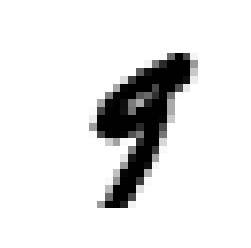

In [10]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=matplotlib.cm.binary, 
               interpolation='nearest')
    plt.axis('off')
plt.show()

plot_digit(some_digit)

In [11]:
y[a]

'9'

## Train-Test Split

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=42)

Verifying data dimensions:

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((56000, 784), (14000, 784), (56000,), (14000,))

## Simple Binary Model

Let's simplify the model by only trying to identify one digit, 5. distinguish between 5 and not-5

In [14]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

Now to pick a classifier and train it. Can use **Stochastic Gradient Descent (SGD) classifier**, using *SGDClassifier* class. Advantage of handling large datasets efficiently. Also deals with training instances independantly, one at a time. Makes it good for online learning.

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

Predicting our digit:

In [16]:
sgd_clf.predict([X[0]])

array([False])

In [17]:
y[0]

'5'

Note it did not gues correctly, let's take a look at some performance measures:

## Performance Measures

Evaluate using K-fold cross validation with 3 folds.
* Splits the training set into 3 folds, makes predictions, then evaluates them on each fold using a model trained on the remaining folds

In [18]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96550062, 0.96266138, 0.94669452])

Seems very accurate, ~95%

    **ASIDE:** Cross-validation performs stratified sampling, but if we need more control over the process can use the code below

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9655006160604275
0.962661381046767
0.9466945248044573


##### But how good is this model, really? It could not predict our 5 above. Let's compare to a model that never predicts 5

In [20]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91107302, 0.90914448, 0.90978249])

The accuracy of this model is over **90%**!
Why?
* Only about 10% of the images are 5s, so if we always guess that an image is not 5, we will be right 90% of the time, $(1 - P(5)) = ~0.9$
So accuracy is not a preferred performance measure for classifiers. Especially when dealing with datasets that are **Unbalanced**

In [22]:
np.unique(y_train_5, return_counts=True)

(array([False,  True]), array([50960,  5040], dtype=int64))

In [23]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [24]:
np.unique(y_train_5)

array([False,  True])

In [25]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train_5, y_train_pred, np.unique(y_train_5)))

[[50669   291]
 [ 2045  2995]]
